In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import stats
import sys
import sklearn
from sklearn.preprocessing import normalize

In [74]:
sys.path.insert(0, '/Users/cynthiachen/Downloads/Internship2019/degron_mutation/deepDegron')
from train_nn import *

In [167]:
# Load pre-trained neural network models from pickle file
model_bag_of_words = pickle.load(open( "../models/neural_network_bag_of_words_v2.pickle", "rb" ))
model_pos_specific = pickle.load(open( "../models/neural_network_pos_specific_v2.pickle", "rb" ))

# Create pd dataframe of sequence information 
degron_pred = pd.read_csv("../data/degron_pred.csv", index_col=0)
# Select column of input sequences
input_seq = degron_pred.iloc[:, 10]

In [76]:
# Use compute_feature_matrix function to encode sequences
features = compute_feature_matrix(input_seq, 6, True)
condensed_features = features[:, 0:20] # Remove zeros at the end for bag of words prediction

In [77]:
# Use pre-trained model to predict sequence degredataion
pred_bow_wt = model_bag_of_words.predict_proba(condensed_features) # wild-type bag of words prediction
pred_ps_wt = model_pos_specific.predict_proba(features)            # wild-type position-specific prediction
drp_wt = pred_ps_wt-pred_bow_wt                                    # wild-type degron regulatory potential

In [78]:
# def mutate(seq, index, newchar):
#     char_list = list(seq)
#     char_list[index] = newchar
#     return "".join(char_list)

In [79]:
# Convert string to 2D list of characters

seqlist = [] # 2D list of all sequences, with each character as 1 entry 
for sequence in input_seq:
    seqlist.append(list(sequence))

### Mutation 1: Shift mutation
Shifts all the characters at a certin position down by 1 sequence, with the first sequence filled by the last sequence

In [80]:
seq_length = len(seqlist[0]) # 23
num_seq = len(seqlist)       # number of total sequences
shift = 1                    # distance to shift characters by

# List that contains the delta DRP for each position when a shift mutation occurs at that position
diff=[]

# Loop to iterate through all sequence positions
for p in range(seq_length):
    first = seqlist[0][pos]
    for i in range(num_seq-shift):
        #for j in range(seq_length) - iterate through positions
        seqlist[i][pos] = seqlist[i+shift][pos]
    seqlist[num_seq-shift][pos]=first
    
    mutated_seqs = []
    for i in range(num_seq):
        mutated_seqs.append("".join(seqlist[i])) 
        
    # Use compute_feature_matrix function to encode sequences
    features = compute_feature_matrix(pd.Series(mutated_seqs), 6, True)
    condensed_features = features[:, 0:20] # Remove zeros at the end for bag of words prediction

    # Use pre-trained model to predict sequence degredataion
    # Use pre-trained model to predict sequence degredataion
    pred_bow_mut = model_bag_of_words.predict_proba(condensed_features) # bag of words prediction
    pred_ps_mut = model_pos_specific.predict_proba(features)            # position-specific prediction
    drp_mut = pred_ps_mut-pred_bow_mut                                  # mutated degron regulatory potential
    
    # Calculate DRP difference in mutated and wild-type (normal) sequence and add this to a list
    diff.append(drp_wt-drp_mut)

In [82]:
average_delta = []
for i in diff:
    average_delta.append(np.average(i))

In [84]:
# # Plot histogram showing distribution of average DRP deltas

# sns.set(color_codes=True)
# x = np.random.normal(size=200)
# sns.distplot(diff)
# plt.show()

# sns.set(color_codes=True)
# x = np.random.normal(size=200)
# sns.distplot(average_delta, bins = 8)
# plt.show()

### Mutation 2: Random shuffle mutation (considering only Top & Bottom scores)
Shifts all the characters at a certain position using random shuffling, and then considers only the select top and bottom sequences

In [243]:
# Sort degron sequence information by regulatory potential in descending order (highest to lowest)
degron_pred_sorted = degron_pred.sort_values(by=['regulatory potential'], ascending=False)

In [244]:
# Select only the "sequence" and "potential" columns and format values into a list
degron_seq_scores = degron_pred_sorted[['Peptide amino acid sequence','regulatory potential']].values.tolist()

### Motif Analysis
Discover patterns that characterize sequences with high & low degron regulatory potential

In [93]:
# Sort degron sequence information by regulatory potential in descending order (highest to lowest)
degron_pred_sorted = degron_pred.sort_values(by=['regulatory potential'], ascending=False
                                             
# Select only the "sequence" and "potential" columns and format values into a list
degron_seq_scores = degron_pred_sorted[['Peptide amino acid sequence','regulatory potential']].values.tolist()

In [217]:
# Function description: 
#
# Cutoff -- number of sequences from the top + bottom to consider for motif analysis
# Motif length -- length of kmer motifs to be considered

def motif(cutoff = 50, motif_length = 2):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    kmer_dict = {}
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - motif_length + 1):
            kmers.append((sequence[j:(j+motif_length)], row[1])) # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # count the frequency of each unique kmer and print 
        #print('Frequency of', unique_kmers[i], 'is :', kmer_list.count(unique_kmers[i]))
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})
    
    # Returns dictionary of [kmer sequence] -> [frequency]
    return kmer_dict

In [ ]:
d = motif()
sorted(d.items(), key=lambda item: item[1])

Motif analysis with DRP score weighting

In [204]:
# Function description: 
#
# Cutoff -- number of sequences from the top + bottom to consider for motif analysis
# Motif length -- length of kmer motifs to be considered

def motif_with_weighting(cutoff = 50, motif_length = 2):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - motif_length + 1):
            kmers.append((sequence[j:(j+motif_length)], row[1])) # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # 
        np.asarrray
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})

ROC curve calculation to statistically determine sequence cutoff

In [ ]:
# roc_auc_score

In [245]:
auc_info = np.asarray(degron_pred_sorted[['Modal Bin','sequence position specific', 'bag of words']])

In [247]:
# Determines true labels based on bins
# Bins 1 & 2 -> 1 (high degradation)
# Bins 3 & 4 -> 0 (low degradation)

for i in range(num_seq):
    mbin = auc_info[:, 0][i]
    if mbin > 2:
        auc_info[:, 0][i] = 0
    else:
        auc_info[:, 0][i] = 1

In [269]:
y_true = auc_info[:, 0]
y_score_ss = auc_info[:, 1] # Sequence-specific prediction scores
y_score_bow = auc_info[:, 2] # Bag of words prediction scores

In [270]:
fp_ss, tp_ss, _ = sklearn.metrics.roc_curve(y_true, y_score_ss)
fp_bow, tp_bow, _ = sklearn.metrics.roc_curve(y_true, y_score_bow)

In [271]:
roc_auc[2] # CHANGE

0.78594771241830075

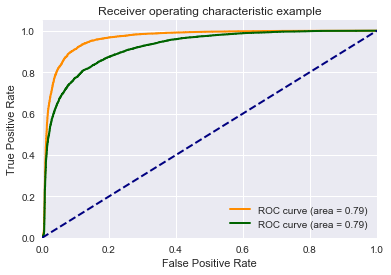

In [272]:
plt.figure()
lw = 2
plt.plot(fp_ss, tp_ss, color='darkorange',
         lw=lw, label='Sequence-specific (area = %0.2f)' % roc_auc[2])
plt.plot(fp_bow, tp_bow, color='darkgreen',
         lw=lw, label='Bag of words (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Automatically created module for IPython interactive environment


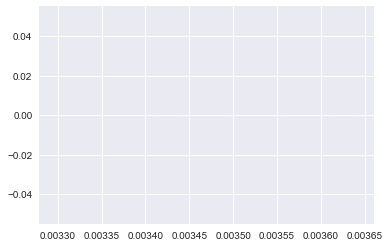

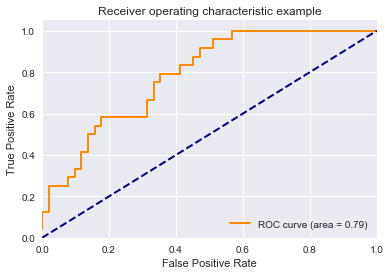

In [260]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [261]:
roc_curve(y_test[:, i], y_score[:, i])

(array([ 0.        ,  0.        ,  0.01960784,  0.01960784,  0.07843137,
         0.07843137,  0.09803922,  0.09803922,  0.11764706,  0.11764706,
         0.1372549 ,  0.1372549 ,  0.15686275,  0.15686275,  0.17647059,
         0.17647059,  0.31372549,  0.31372549,  0.33333333,  0.33333333,
         0.35294118,  0.35294118,  0.41176471,  0.41176471,  0.45098039,
         0.45098039,  0.47058824,  0.47058824,  0.50980392,  0.50980392,
         0.56862745,  0.56862745,  1.        ]),
 array([ 0.04166667,  0.125     ,  0.125     ,  0.25      ,  0.25      ,
         0.29166667,  0.29166667,  0.33333333,  0.33333333,  0.41666667,
         0.41666667,  0.5       ,  0.5       ,  0.54166667,  0.54166667,
         0.58333333,  0.58333333,  0.66666667,  0.66666667,  0.75      ,
         0.75      ,  0.79166667,  0.79166667,  0.83333333,  0.83333333,
         0.875     ,  0.875     ,  0.91666667,  0.91666667,  0.95833333,
         0.95833333,  1.        ,  1.        ]),
 array([ 0.58431039,  0.21